In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
from scipy.stats import gaussian_kde
import pyproj
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

# Plots of KL20 nereocystis

## set up

Directories

In [21]:
datadir = 'data/'
spdir = 'KL20_nereocystis/'
indir = 'output_byChr_byPop_params01/'
outdir = 'output_spacetrees/'
plotdir = 'plots/'

Sample locations

In [22]:
sample_locations = np.loadtxt(datadir + spdir + outdir + 'locations.txt')
n,d = sample_locations.shape

In [23]:
sample_extent = [min(sample_locations[:,1])-1,max(sample_locations[:,1])+1,min(sample_locations[:,0])-1,max(sample_locations[:,0])+1]

robinson_extent = [-141,-136,46,62] #got this by trial and error 

metadata

In [24]:
metadata_file = datadir + spdir + 'geographicCoords_KL20_nereocystis.txt'
metadata = []
with open (metadata_file,'r') as f:
    next(f)
    for line in f:
      for _ in range(2):
        metadata.append(line.split())

colors

In [25]:
colors = [i[5] for i in metadata]

In [26]:
colormap = {'aquamarine3': '#66CCDA', 'dodgerblue4': '#104E8B', 'lightskyblue1': '#B0E2FF', 'mediumorchid4': '#D15FEE', 'olivedrab': '#6B8E23', 'plum': '#DDA0DD', 'steelblue2': '#BCD2EE', 'NA': 'gray'}

sample locations colored by structure group

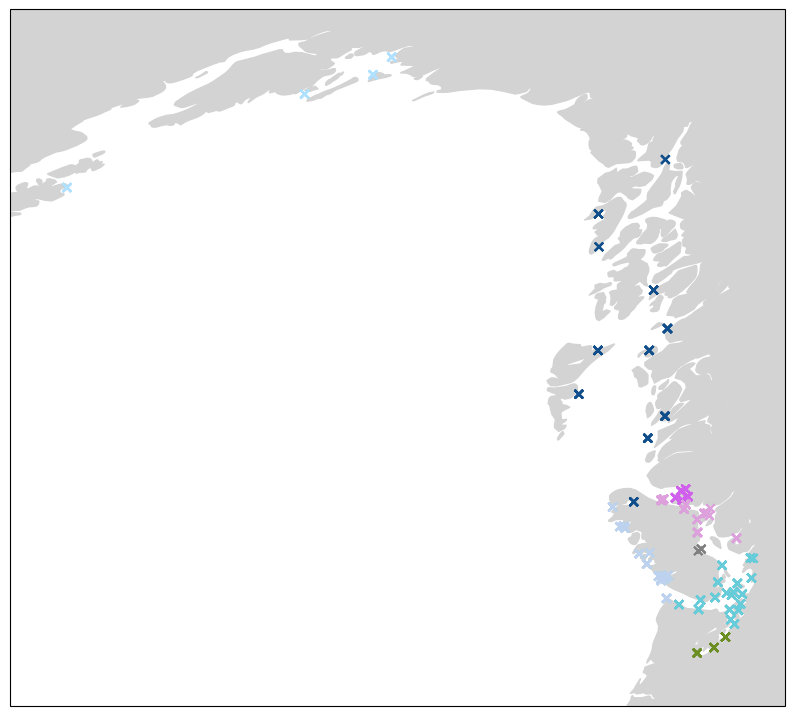

In [27]:
fig = plt.figure(figsize=(10,10))

projection = ccrs.Robinson()
data_crs = ccrs.PlateCarree() #data supplied in lat/long


ax = plt.axes(projection=projection)
ax.add_feature(cfeature.LAND, color='lightgray')

ax.scatter(sample_locations[:,1], sample_locations[:,0], transform=data_crs, color=[colormap[c] for c in colors], marker='x')
# ax.scatter(np.mean(sample_locations[:,1]), np.mean(sample_locations[:,0]), transform=data_crs, color='k', marker='o')
ax.set_extent(robinson_extent, crs=data_crs)

plt.show()

chromosomes (1 is a sex chromosome so excluded from relate)

In [28]:
CHRS = [str(i).zfill(2) for i in range(2,41)]

number of trees per chromosome (to use at top of Snakefile)

In [29]:
num_trees = []
for CHR in CHRS:
    with open(datadir + spdir + indir + 'JARUPZ0100000%s.1_popsize_params01.anc' %CHR) as f:
        next(f)
        num_trees.append(int(next(f).split()[1]))

In [30]:
np.array(num_trees)

array([28118, 16956, 16553, 13043, 12361, 15495, 14149,  6627, 13012,
       15276, 15903, 10979, 10614,  9554, 14752,  8389, 13377, 12746,
       13122, 11878,  8490, 13872, 10678,  4481,  7429, 13211,  7009,
        8018,  8866,  6670,  7125,  8714,  6758,  6866,  4611,  5982,
        3568,  1999,  5012])

Ancestor locations

In [32]:
fns = [fn for fn in sorted(glob.iglob(datadir + spdir + outdir + 'JARUPZ0100000*_100M_NoneT_Alls_Allt.blup_locs'))]
locs = np.array([np.loadtxt(fn, delimiter=',') for fn in fns])
L = len(locs)
n = len(sample_locations)
T = int(locs.shape[1]/n)
ancestor_times = locs[0,:T,1]
anc_locs = locs[:,:,-2:].reshape(L,n,T,d)
anc_locs.shape

(844, 898, 10, 2)

In [33]:
ancestor_times

array([1.0e+01, 1.0e+02, 1.0e+03, 2.5e+03, 5.0e+03, 1.0e+04, 2.0e+04,
       4.0e+04, 1.0e+05, 1.0e+06])

convenient structure groups

In [34]:
popid = np.unique(np.array(metadata)[:,2], return_inverse=True)[1]

In [35]:
popgroups = []
popcolors = []
for i in range(max(popid)+1):
    popgroups.append([j for j,p in enumerate(popid) if p==i])
    popcolors.append(colors[popgroups[i][0]])

subsample

In [36]:
set03 = [int(i[-1]) for i in metadata]
set03_sample_locations = np.array([j for i,j in enumerate(sample_locations) if set03[i]==1])
set03_colors = np.array([j for i,j in enumerate(colors) if set03[i]==1])
set03_popid = np.unique(np.array([j for i,j in enumerate(metadata) if set03[i]==1])[:,2], return_inverse=True)[1]
set03_popgroups = []
set03_popcolors = []
for i in range(max(set03_popid)+1):
    set03_popgroups.append([j for j,p in enumerate(set03_popid) if p==i])
    set03_popcolors.append(set03_colors[set03_popgroups[i][0]])

In [38]:
fns = [fn for fn in sorted(glob.iglob(datadir + spdir + outdir + 'JARUPZ0100000*_100M_set03_NoneT_Alls_Allt.blup_locs'))]
locs = np.array([np.loadtxt(fn, delimiter=',') for fn in fns])
L = len(locs)
n = sum(set03)
T = int(locs.shape[1]/n)
anc_locs_set03 = locs[:,:,-2:].reshape(L,n,T,d)
anc_locs_set03.shape

(844, 242, 10, 2)

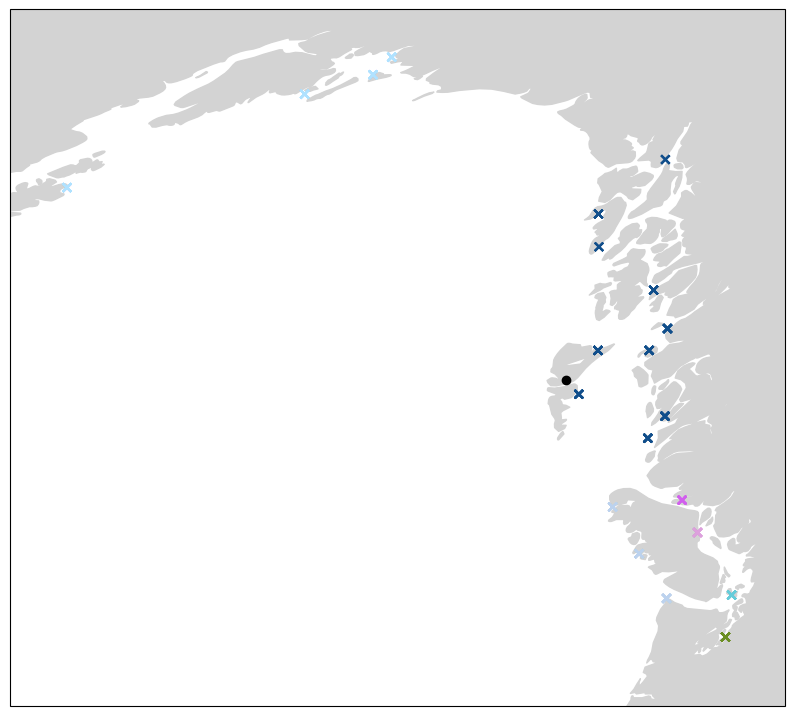

In [39]:
fig = plt.figure(figsize=(10,10))

projection = ccrs.Robinson()
data_crs = ccrs.PlateCarree() #data supplied in lat/long


ax = plt.axes(projection=projection)
ax.add_feature(cfeature.LAND, color='lightgray')

ax.scatter(set03_sample_locations[:,1], set03_sample_locations[:,0], transform=data_crs, color=[colormap[c] for c in set03_colors], marker='x')
ax.scatter(np.mean(set03_sample_locations[:,1]), np.mean(set03_sample_locations[:,0]), transform=data_crs, color='k', marker='o')
ax.set_extent(robinson_extent, crs=data_crs)

plt.show()

## all ancestors

In [44]:
# contours really slow this down

def all_ancestors(anc_locs,sample_locations,time_ix,extent=robinson_extent,samples=[range(n)],colors=[plt.cm.tab10(0)],figsize=(5,5),contour_alpha=0.25,scatter=True,contour=False,group_contours=False,means=False):
    
    fig = plt.figure(figsize=figsize)
    projection = ccrs.Robinson()
    data_crs = ccrs.PlateCarree() #data supplied in lat/long
    ax = plt.axes(projection=projection)
    ax.add_feature(cfeature.LAND, color='lightgray')

    # all ancestors of group at given time
    for i,group in enumerate(samples):
        all_locs = []
        for sample in group:
            locs = anc_locs[:, sample, time_ix]
            all_locs.append(locs)
        all_locs = np.vstack(all_locs)

        # all ancestors of group
        if scatter:
            ax.scatter(all_locs[:, 1], all_locs[:, 0], color=colors[i], zorder=0, transform=data_crs, alpha=0.05, s=5, marker='.')

        # group mean
        if means:
            ax.scatter(np.nanmean(all_locs[:, 1]), np.nanmean(all_locs[:, 0]), color=colors[i], zorder=2, transform=data_crs, alpha=1, marker='o', edgecolor='k')

        # group contour
        if group_contours:
            sns.kdeplot(x=all_locs[:, 1], y=all_locs[:, 0], transform=data_crs, ax=ax, levels=10, color=colors[i], bw_adjust=1, zorder=1, linewidths=1, alpha=contour_alpha)

    # one contour for all samples
    if contour:
        sns.kdeplot(x=np.hstack(anc_locs[:,:,time_ix,1]), y=np.hstack(anc_locs[:,:,time_ix,0]), transform=data_crs, ax=ax, levels=10, color='k', bw_adjust=1, zorder=1, linewidths=1, alpha=contour_alpha)
    
    # mean sample location for comparison
    ax.scatter(np.mean(sample_locations[:,1]), np.mean(sample_locations[:,0]), transform=data_crs, color='k', marker='o', zorder=2) #mean sample location
    
    ax.set_extent(extent)
    ax.text(0.5, 1.01, '%d generations ago' % int(ancestor_times[time_ix]), ha='center', fontsize=14, transform=ax.transAxes)
    
    plt.tight_layout()
    # plt.savefig(plotdir + 'wohns_4b.png')
    plt.show()

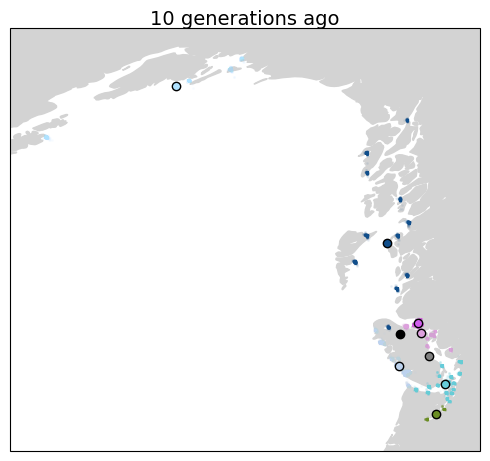

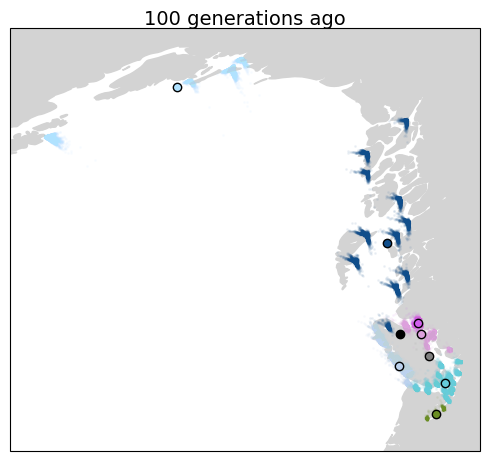

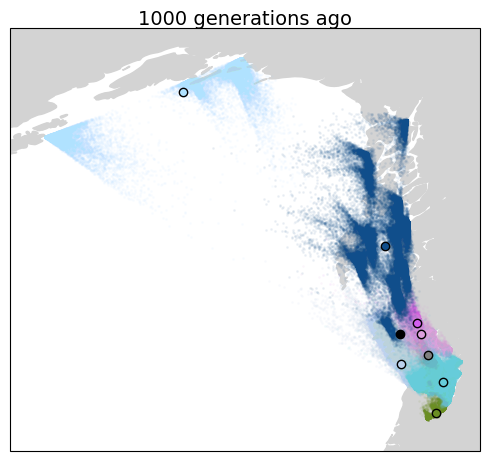

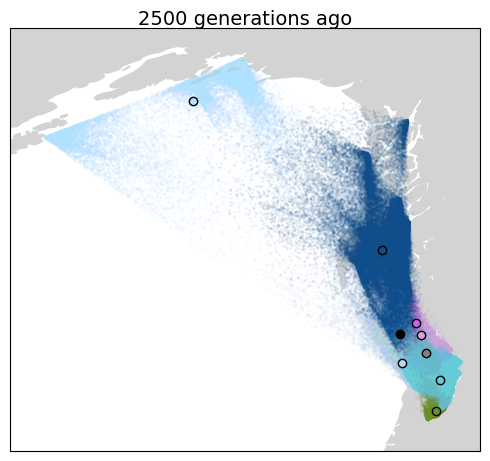

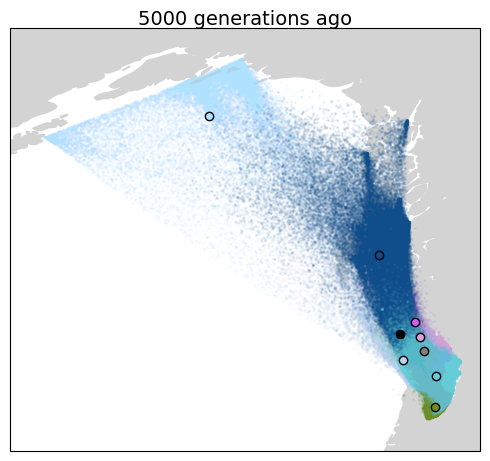

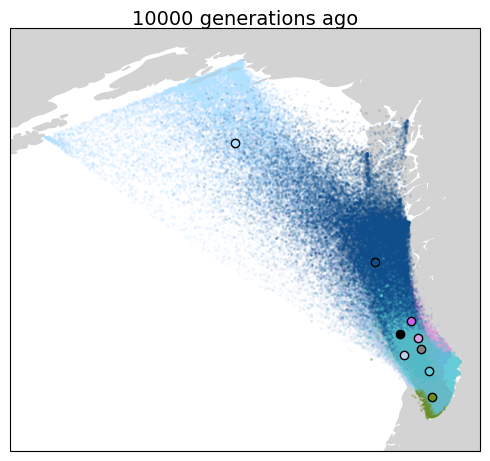

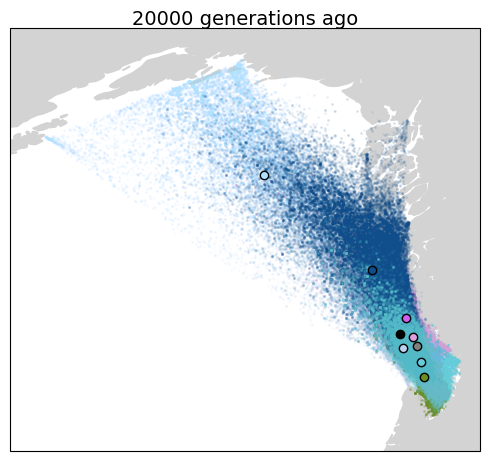

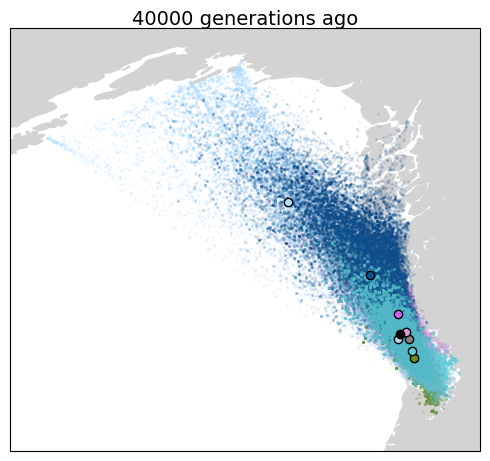

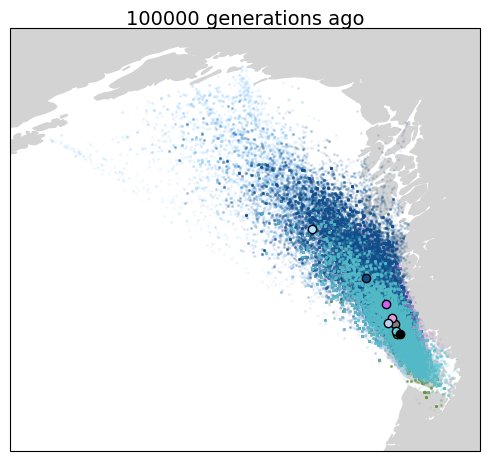

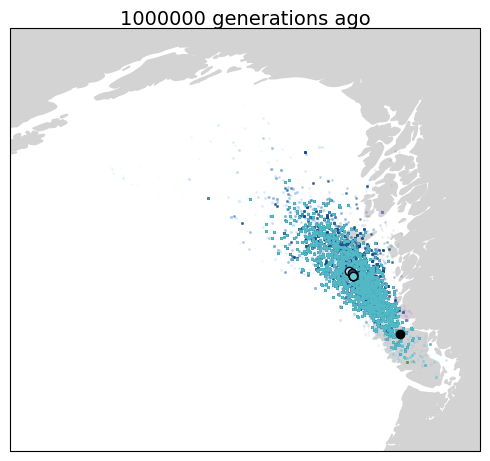

In [45]:
for i in range(T):
    all_ancestors(anc_locs, sample_locations, i, samples=popgroups, colors=[colormap[c] for c in popcolors], means=True)

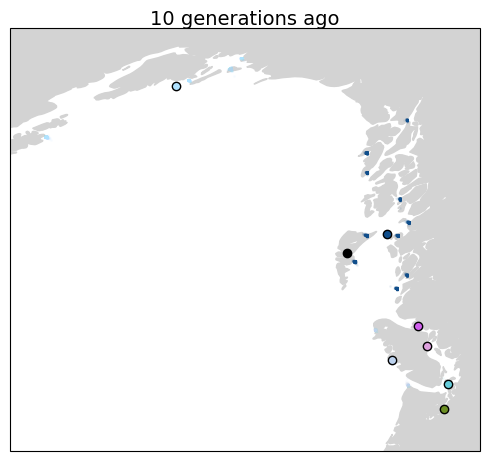

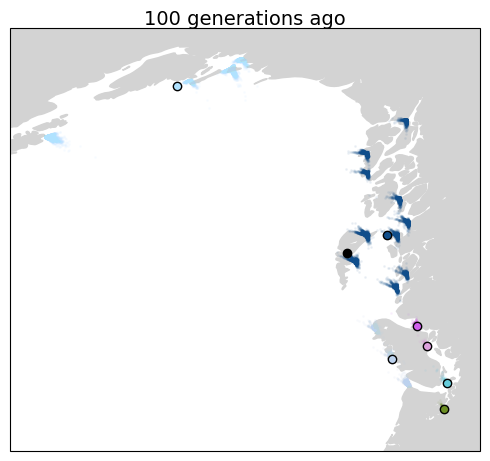

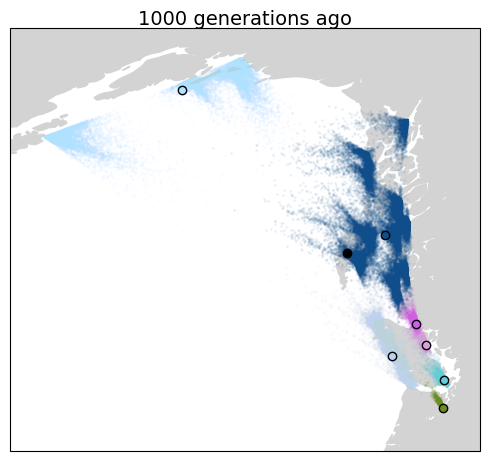

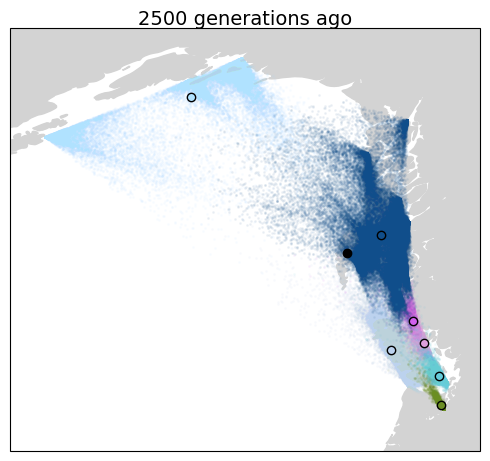

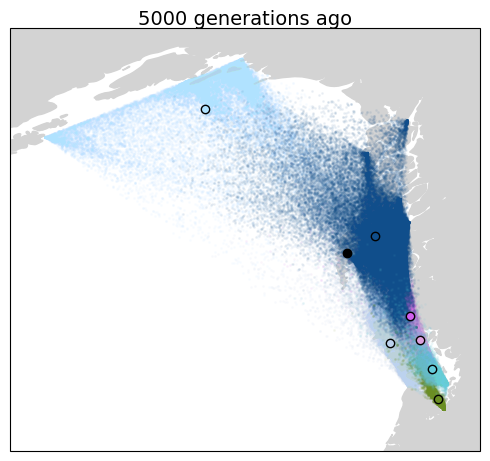

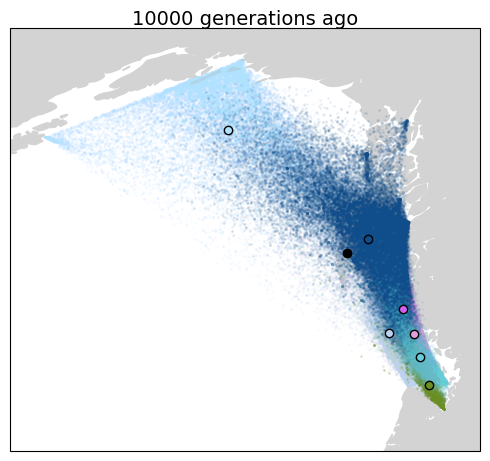

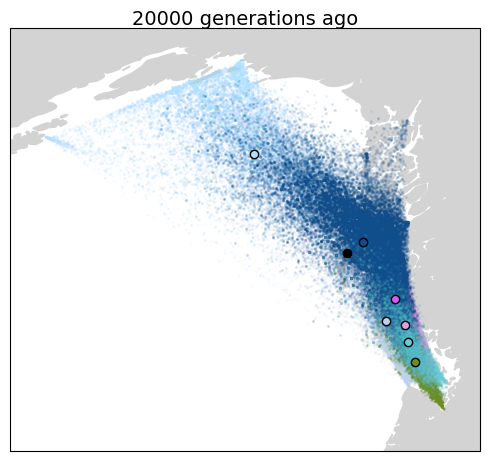

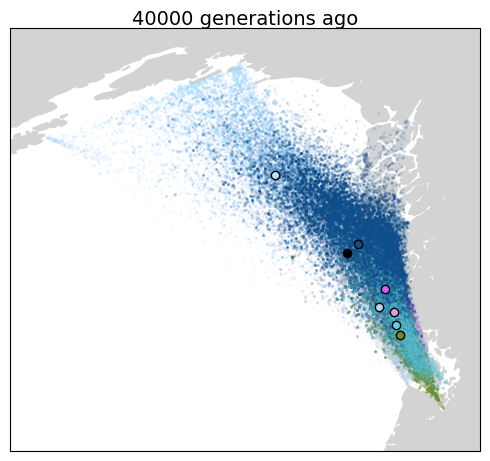

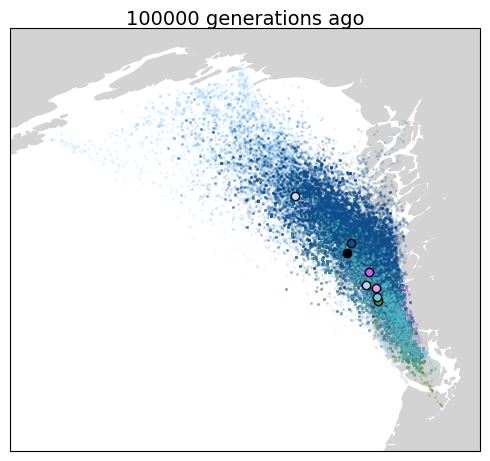

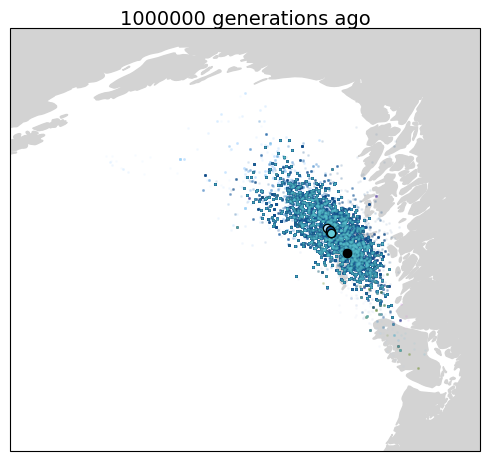

In [46]:
for i in range(T):
    all_ancestors(anc_locs_set03, set03_sample_locations, i, samples=set03_popgroups, colors=[colormap[c] for c in set03_popcolors], means=True)

## mean trajectories

In [52]:
def mean_trajectories(anc_locs,sample_locations,time_ixs,m=10,extent=robinson_extent,samples=range(n),figsize=(5,5),logscale=False,colors=colors):
    
    fig = plt.figure(figsize=figsize)
    projection = ccrs.Robinson()
    data_crs = ccrs.PlateCarree() #data supplied in lat/long
    geodetic = ccrs.Geodetic() #for great circles
    ax = plt.axes(projection=projection)
    ax.add_feature(cfeature.LAND, color='lightgray')
    cmap = plt.get_cmap("plasma_r")

    maxtime = ancestor_times[max(time_ixs)]
    
    for sample in samples: #for each sample
    
        prev_time = 0
        prev_mean_loc = sample_locations[sample]
        for time_ix in time_ixs:
            time = ancestor_times[time_ix]
            mean_loc = np.nanmean(anc_locs[:,sample,time_ix], axis=0)
            xs, ys, ts = np.linspace(prev_mean_loc[1],mean_loc[1],m), np.linspace(prev_mean_loc[0],mean_loc[0],m), np.linspace(prev_time,time,m) #linear interpolation
            for i in range(1,m):
                color = cmap(ts[i]/maxtime)
                if logscale:
                    color = cmap(np.log10(ts[i])/np.log10(maxtime))
                ax.plot([xs[i-1],xs[i]], [ys[i-1],ys[i]], color=color, lw=1, alpha=0.5, transform=geodetic)
            prev_time = time
            prev_mean_loc = mean_loc

    ax.scatter(sample_locations[:,1], sample_locations[:,0], transform=data_crs, color=[colormap[c] for c in colors], marker='o')
    ax.scatter(np.mean(sample_locations[:,1]), np.mean(sample_locations[:,0]), transform=data_crs, color='k', marker='o', zorder=1e5) #mean sample location
    
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax, orientation='horizontal', pad=0.01, shrink=0.9)
    cbar.set_ticks(np.linspace(0,1,3))
    if logscale:
        cbar.set_ticklabels([int(i) for i in np.logspace(0,np.log10(maxtime),3)])
    else:
        cbar.set_ticklabels([int(i) for i in np.linspace(0,maxtime,3)])
    cbar.set_label(('generations ago'), fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    
    ax.set_extent(extent)
    
    plt.tight_layout()
    # plt.savefig(plotdir + 'wohns_4b.png')
    plt.show()

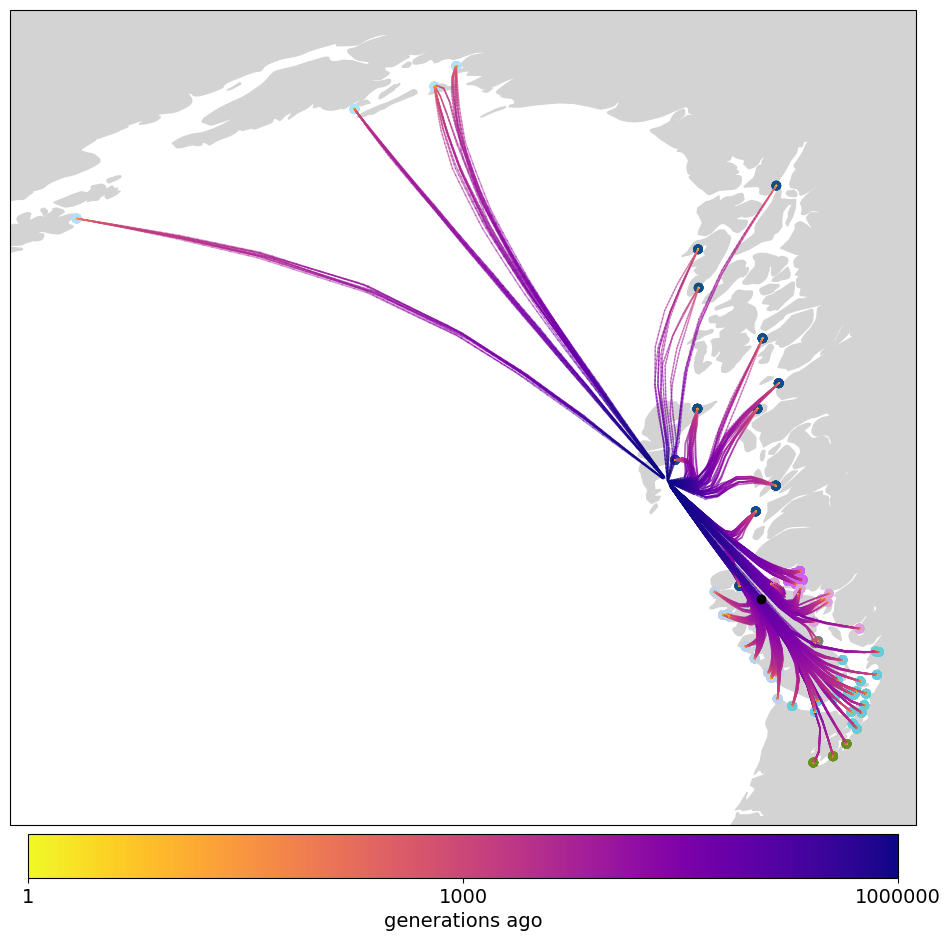

In [53]:
mean_trajectories(anc_locs, sample_locations, samples = range(len(sample_locations)), time_ixs=range(T), figsize=(10,10), logscale=True)

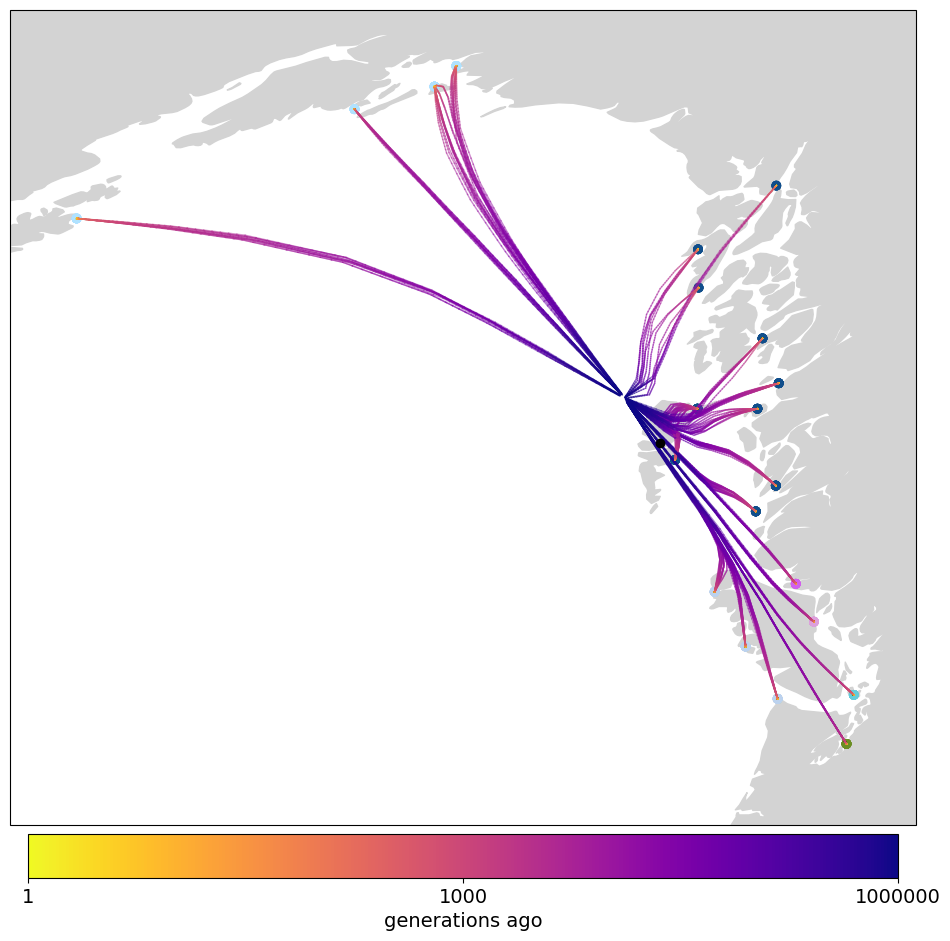

In [54]:
mean_trajectories(anc_locs_set03, set03_sample_locations, samples = range(len(set03_sample_locations)), time_ixs=range(T), figsize=(10,10), logscale=True, colors=set03_colors)

## densities

In [55]:
def hex_density(anc_locs,sample_locations,time_ix,samples=range(n),extent=robinson_extent,figsize=(5,5)):

    fig = plt.figure(figsize=figsize)
    
    projection = ccrs.Robinson()
    data_crs = ccrs.PlateCarree() #data supplied in lat/long
    cmap = plt.get_cmap("Reds")
    
    ax = plt.axes(projection=projection)
    ax.add_feature(cfeature.LAND, color='lightgray')

    # locations of all ancestors of all samples at this time
    all_locs = []
    for sample in samples:
        all_locs.append(anc_locs[:, sample, time_ix])
    all_locs = np.vstack(all_locs) 

    # histogram
    binlims = ax.projection.transform_points(data_crs, np.array(extent[:2]), np.array(extent[-2:])) 
    # ax.hexbin(x=all_locs[:,0], y=all_locs[:,1], transform=data_crs, cmap=cmap, gridsize=[30,10], alpha=0.5, extent=[binlims[0,0], binlims[1,0], binlims[0,1], binlims[1,1]])
    ax.hexbin(x=all_locs[:,1], y=all_locs[:,0], transform=data_crs, cmap=cmap, gridsize=[35,20], extent=[binlims[0,0], binlims[1,0], binlims[0,1], binlims[1,1]], alpha=0.5, mincnt=1)

    ax.scatter(np.mean(sample_locations[:,1]), np.mean(sample_locations[:,0]), transform=data_crs, color='k', marker='o', zorder=1e5) #mean sample location
    
    text = '%d generations ago' %int(ancestor_times[time_ix])
    ax.text(0.5,1.01,text,transform = ax.transAxes, ha='center', fontsize=14)

    ax.set_extent(extent)
    # ax.set_extent([xlims[0],xlims[1],ylims[0],ylims[1]], crs=data_crs)
    
    plt.tight_layout()
    # plt.savefig(plotdir + 'grundler_4.png')
    plt.show()

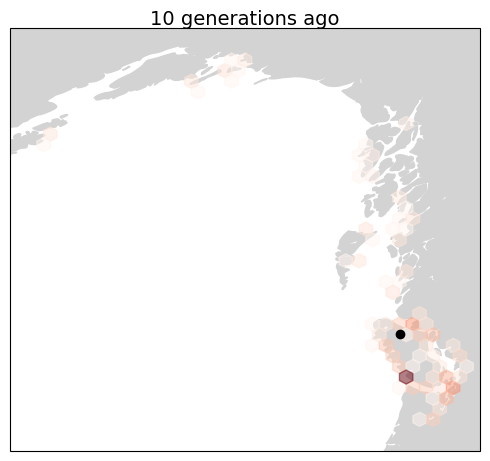

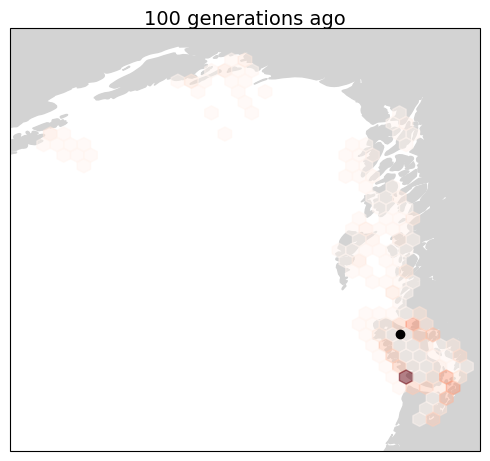

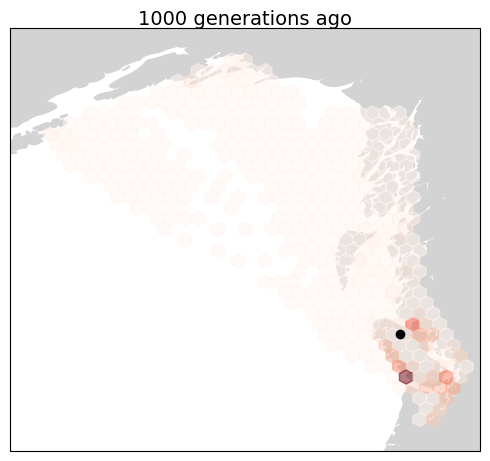

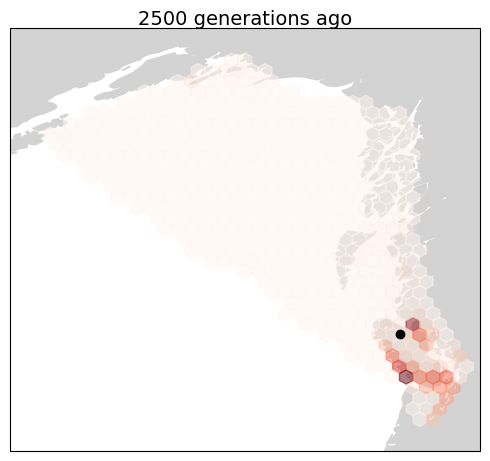

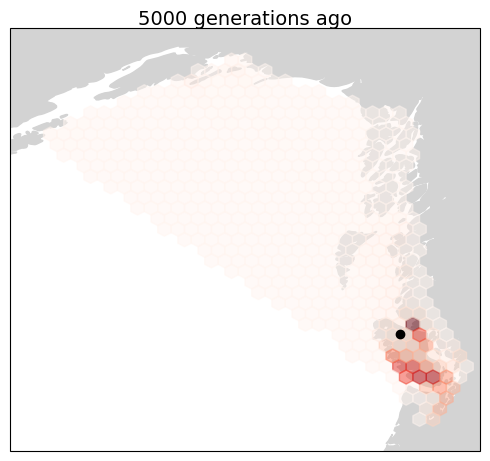

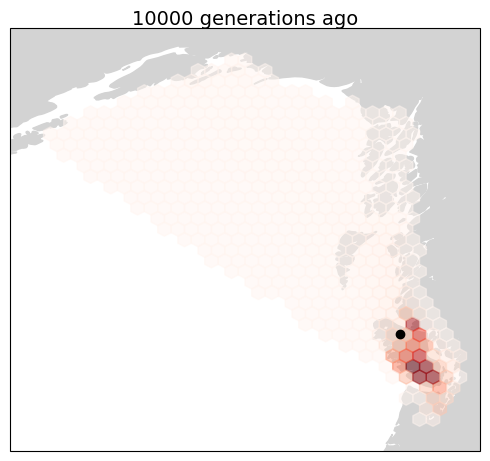

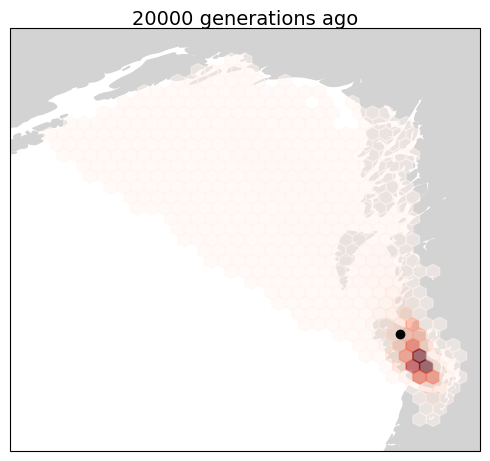

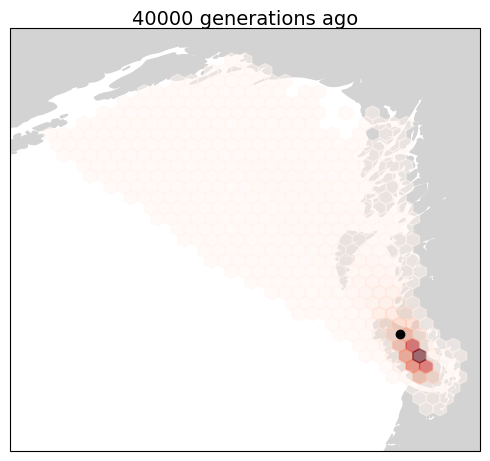

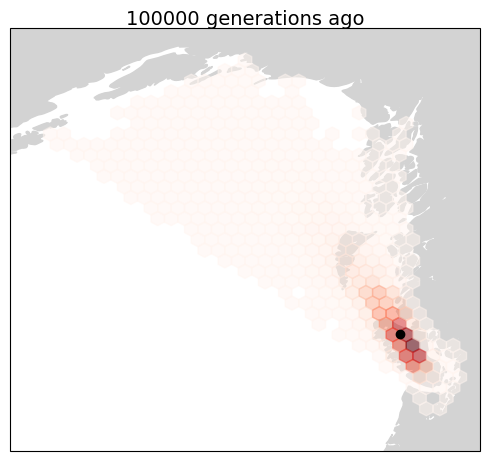

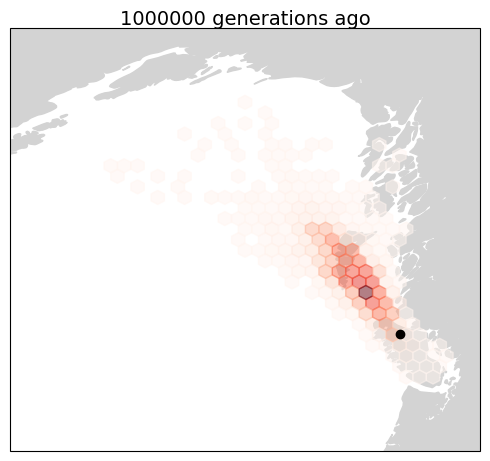

In [56]:
for i in range(T):
    hex_density(anc_locs,sample_locations,i,samples = range(len(sample_locations)))

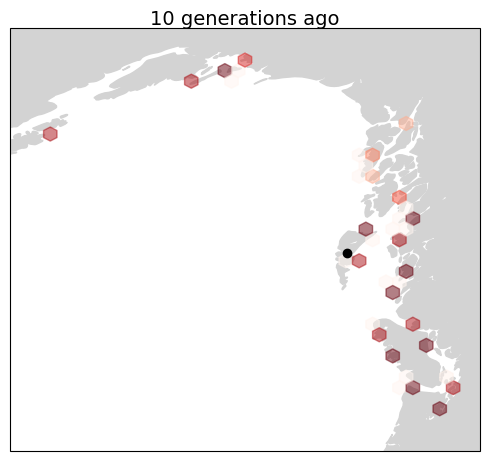

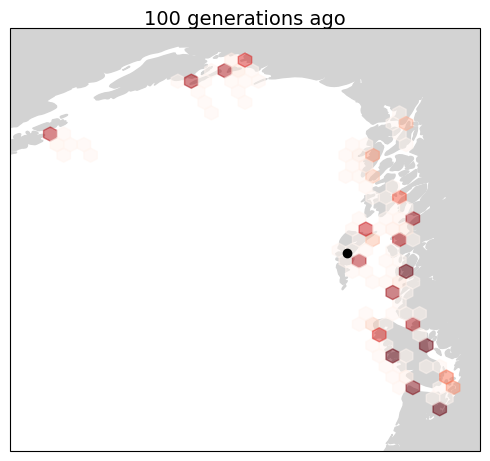

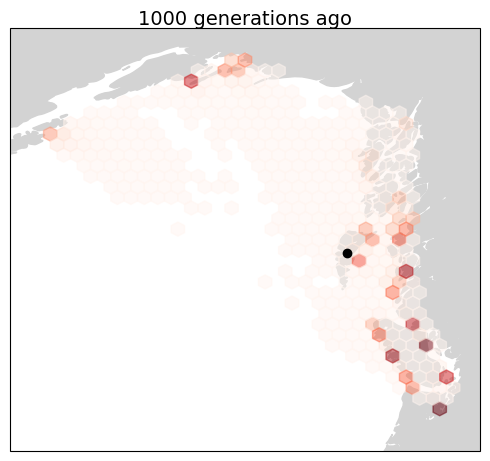

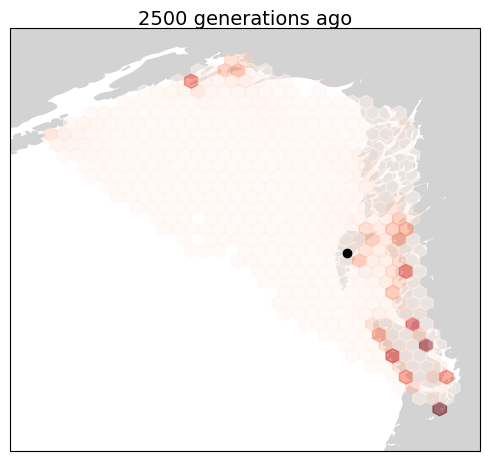

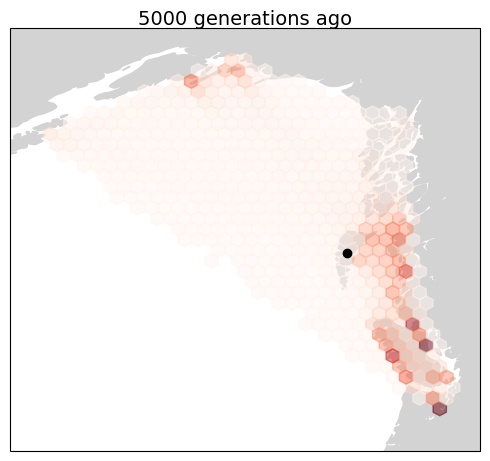

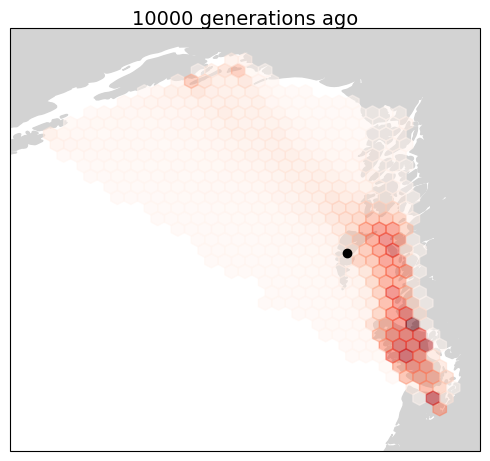

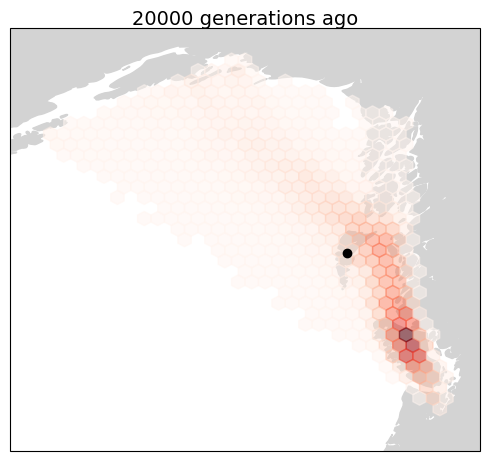

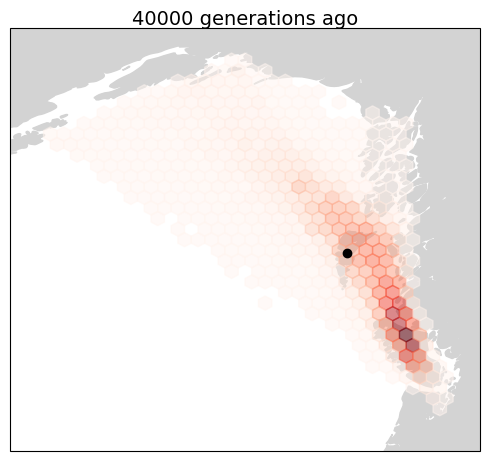

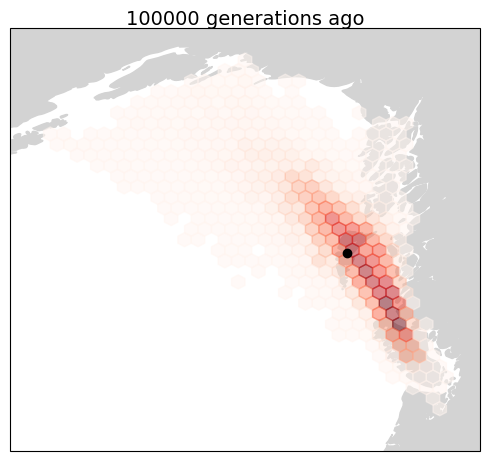

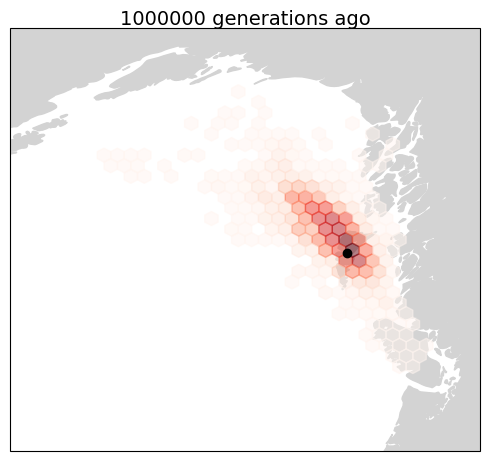

In [57]:
for i in range(T):
    hex_density(anc_locs_set03,set03_sample_locations,i,samples = range(len(set03_sample_locations)))